<a href="https://colab.research.google.com/github/evanolsdal/IBM_Tools_for_Data_Science/blob/main/TimeGAN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Overview**

This notebook walks through the steps of loading in the code and data, preprocessing the data, loading the network, training the network, and finally visualizing the results.

## Instal and Load Modules

Clone the github repository, then install and load the necessary modules.

First Connect to the repo direcotry. This only needs to be done once, so if this is first time opening notebook on own drive then uncomment the line of code below and run this cell to download git repo to files and move to it.

In [ ]:
# Get git repo

!git clone https://github.com/evanolsdal/TimeGAN-Finance-Project

fatal: destination path 'TimeGAN-Finance-Project' already exists and is not an empty directory.


In [ ]:
# change to repo directory

%cd TimeGAN-Finance-Project/

/content/TimeGAN-Finance-Project


If updates are made to the repo run the following lines to load the latest version.

In [ ]:
# fetch changes made to remote repository
!git fetch

In [ ]:
# merge the fetched changes with the current local repository
!git merge origin/main

Already up to date.


Next install the requirements and load the modules.

In [ ]:
!pip install -r requirements.txt

In [ ]:
import numpy as np
from src.timeGAN import TimeGAN
from data_preprocessing import processing as p
from src import visualizations as v

## Data Preprocessing

Next get the data and transform it into the right shape for training.

This is done in the following order:


1.   Load raw data, one for dates and one for values
2.   Transform values to percentage change
3.   Generate sequences



In [ ]:
# load data
dates = p.import_data("SP500 raw.csv", True)
data = p.import_data("SP500 raw.csv", False)

# transform to % change
data = p.transform_percent_change(data)

# generate sequences
seq_length = 24
sequences, scaler = p.generate_sequences(data, seq_length, True, 10, 'normalize')

You can print the sequences below to make sure they are in the right form.

In [ ]:
np.shape(sequences)
print(sequences)

[[[ 0.13149884  0.08700655  0.17036405  0.18163906 -0.27240545]
  [ 0.1725779   0.06558915  0.19829869  0.15945365 -0.27229307]
  [ 0.11866947  0.06072431  0.13801692  0.18758268 -0.44557291]
  ...
  [ 0.01046625 -0.17143839 -0.14778826 -0.0767741  -0.22256609]
  [-0.31725082 -0.27668591 -0.47752443 -0.26183425 -0.08530052]
  [-0.65146336 -0.37687797 -0.12632968  0.28499671 -0.19874677]]

 [[ 0.1725779   0.06558915  0.19829869  0.15945365 -0.27229307]
  [ 0.11866947  0.06072431  0.13801692  0.18758268 -0.44557291]
  [ 0.11457528  0.00799686  0.14183212  0.13730399 -0.31493691]
  ...
  [-0.31725082 -0.27668591 -0.47752443 -0.26183425 -0.08530052]
  [-0.65146336 -0.37687797 -0.12632968  0.28499671 -0.19874677]
  [ 0.49558025  0.13438074  0.5378769   0.07492766 -0.53981964]]

 [[ 0.11866947  0.06072431  0.13801692  0.18758268 -0.44557291]
  [ 0.11457528  0.00799686  0.14183212  0.13730399 -0.31493691]
  [ 0.09840775  0.03989975  0.14442125  0.13393971 -0.24646485]
  ...
  [-0.65146336 -0.

You can also visualize some of the sequences to make sure everything looks correct.

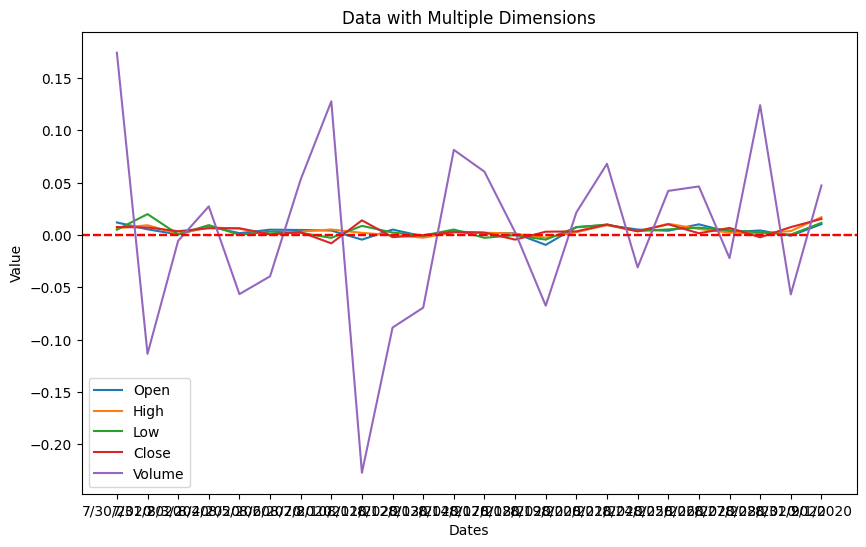

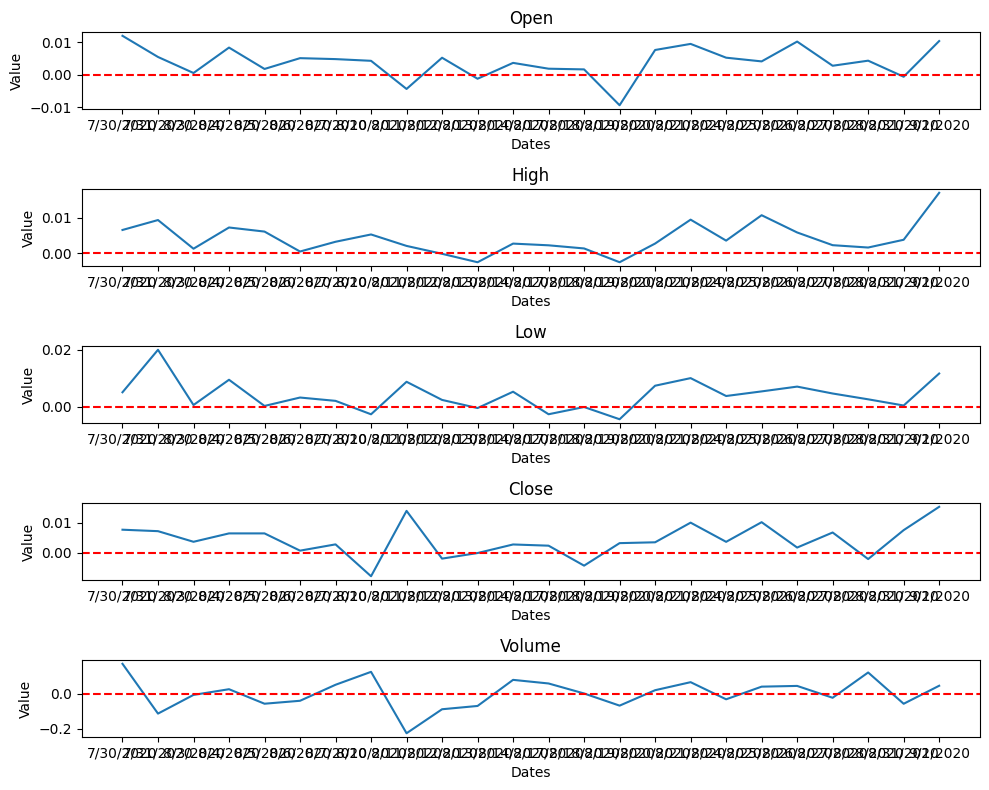

In [ ]:
feature_labels = ["Open","High","Low","Close","Volume"]
v.plot_real_sequence(dates, data, feature_labels, seq_length)

## Initializing Model

Now it's time to initialize the TimeGAN model. Start by defining all of the input parameters, then use them to initialize the model.

The TimeGAN input parameters are the following:

1. model_dimensions: a dict containing all of the dimension needed for the model, containing
   * seq_length: length of time steps
   * input_features: number of features given to the embedder
   * output_features: number of features to output
   * embedded_dims: number of dimensions desired for hidden layers
2.  model_parameters: a dict containing all of the parameters used to set up the model
   * n_layers: number of layers desired for each time step
   * mu: regularizes the generator supervised loss when training the generator
   * phi: regularizes the generator supervised loss when training the supervisor
   * lambda: regularizes the supervised loss when training the embedder
   * alpha_1: learning rate for the Adam optimizer in autoencoder training
   * alpha_2: learning rate for the Adam optimizer in dynamic training
   * theta: scaling factor for the tanh function
3. loss_funcitons: a dict containing all of the loss functions used for training
   * reconsruction_loss: loss for the autoencoder
   * supervised_loss: supervised loss function
   * unsupervised_loss: unsupervised loss function
4. batch_size: batch size for training

In [ ]:
# First import the loss functions
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

# Next define the input parameters
model_dimensions = {"seq_length":seq_length, "input_features":10, "output_features":5, "embedded_dims":5}
model_parameters = {"n_layers":3, "mu":.5, "phi":.25, "lambda":0.1, "alpha_1":0.005, "alpha_2":0.001, "theta":2}
loss_functions = {"reconstruction_loss":MeanSquaredError(),
                      "supervised_loss":MeanSquaredError(),
                      "unsupervised_loss":BinaryCrossentropy()}
batch_size = 100

Next use these to initialize a timegan model

In [ ]:
model = TimeGAN(model_dimensions, model_parameters, loss_functions, batch_size)

Make sure that the model parts are correctly constructed

In [ ]:
model.get_summary()

And finally compile so it's ready for training

In [ ]:
model.compile()

# Training

The training can be broken down into three separate steps:

1. **Autoencoder Training:** This trians the models embedded representation and corresponding recovery function for. The embedder helps facilitate the learning of the generator later on, as the embedded representation provides a simplified space for the generator to mimic.
2. **Supervisor Training:** This trains the models supervisor to learn the stepwise dynamics of the real data in the embedded space. This will be used later to force the generator's output to adhere to the same stepwise dynamics as the real data.
3. **Dynamic Training:** This trains the models generator and discriminator in a dynamic game, and is responsible for the generative nature of GANs.

In the following sections each section is trained separately, for parameter tuning purposes. Then all parts are trained together at the end.

## Autoencoder Training

This part trains the autoencoder for and embedding and recovery pair that can effectively reconstruct the encoded data.

In [ ]:
autoencoder_losses = model.fit_autoencoder(sequences, 4)

Starting Autoencoder Training


Epoch 0, step 0: Reconstruction loss = 1.1112167835235596, Supervised loss = 1.1456347703933716
Epoch 0, step 1: Reconstruction loss = 1.1627304553985596, Supervised loss = 0.9213917851448059
Epoch 0, step 2: Reconstruction loss = 1.1195662021636963, Supervised loss = 0.7639428377151489
Epoch 0, step 3: Reconstruction loss = 1.0510417222976685, Supervised loss = 0.5924407839775085
Epoch 0, step 4: Reconstruction loss = 1.0462771654129028, Supervised loss = 0.518101155757904
Epoch 0, step 5: Reconstruction loss = 1.0180835723876953, Supervised loss = 0.41038253903388977
Epoch 0, step 6: Reconstruction loss = 1.1126948595046997, Supervised loss = 0.3203524053096771
Epoch 0, step 7: Reconstruction loss = 1.0992282629013062, Supervised loss = 0.30700528621673584
Epoch 0, step 8: Reconstruction loss = 1.1810009479522705, Supervised loss = 0.21347051858901978
Epoch 0, step 9: Reconstruction loss = 0.927935779094696, Supervised loss = 0.21160195767879486
Epoch 0, step 10: Reconstruction loss 

Next we plot the losses from the autoencoder training.

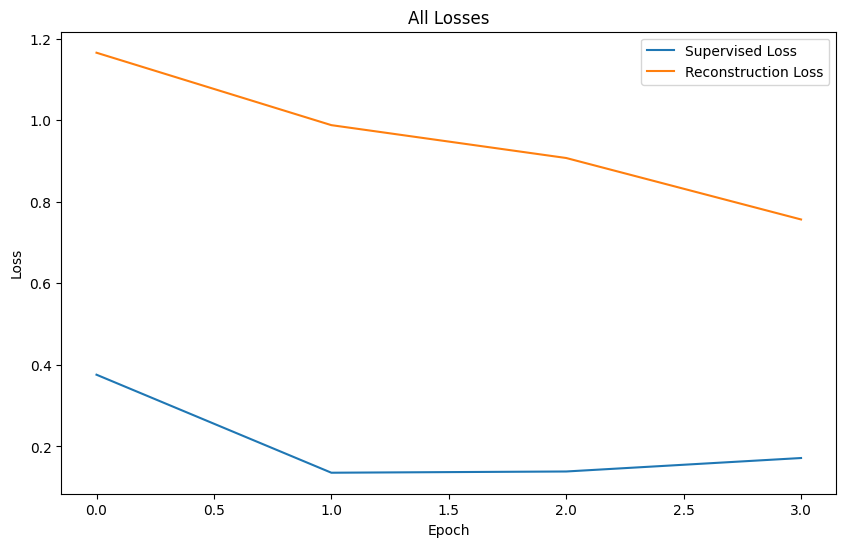

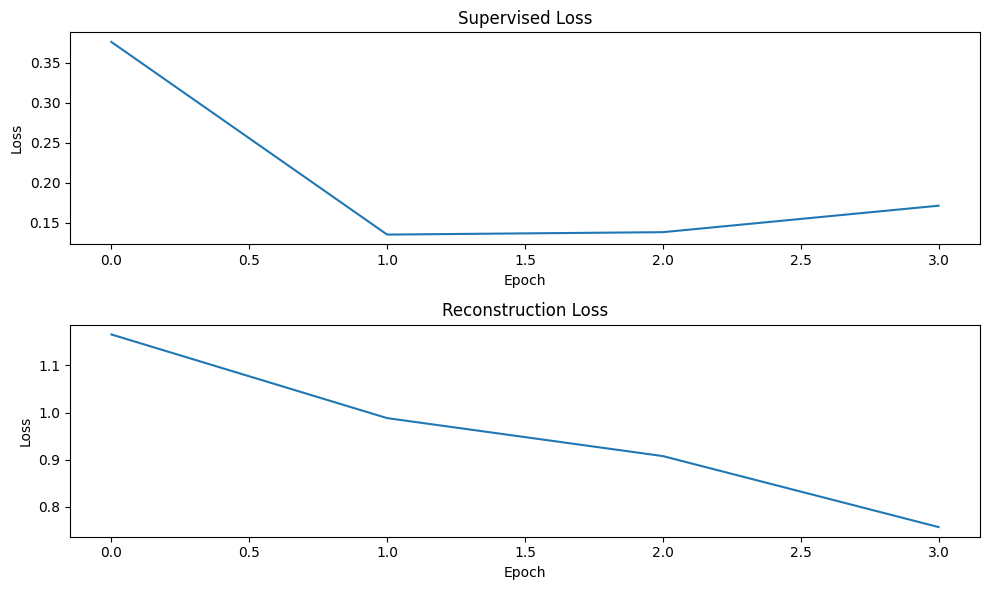

In [ ]:
v.plot_losses(autoencoder_losses)

Then plot a comparison of a real data sequence to its corresponding recovered sequence for one of the features.

In [ ]:
v.plot_autoencoded_sequence(model, sequences, 1, feature_labels)

NameError: ignored

Then save the model to the current point

## Dynamic Training

This part trains the dynamic game between the generator and discriminator to generate the synthetic data.

In [ ]:
dynamic_losses = model.fit_dynamic_game(sequences, 3, 2)

Starting Dynamic Training


NameError: ignored

Next plot the losses from the dyanmic training.

In [ ]:
v.plot_losses(dynamic_losses)

Then plot a comparison of some of the real autoencoded data and a generated sequence.

In [ ]:
v.plot_generated_sequence(model, sequences, 0, feature_labels)